<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objectives
- To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
- To understand the importance of a complex loss function.
- To see how we can optimize not only over network parameters, but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files
import math

In [2]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving IMG_5323.jpg to IMG_5323.jpg

Upload Style Image


Saving The-Starry-Night.jpg to The-Starry-Night.jpg
Content Path: <_io.BytesIO object at 0x7f2c152f1350>
Style Path: <_io.BytesIO object at 0x7f2c34134290>


In [3]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


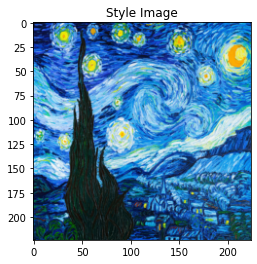

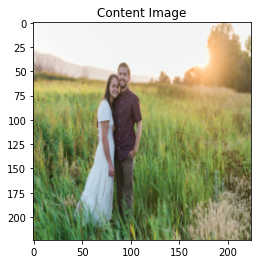

In [4]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a network instance to extract the layers needed for statistics

**TODO:**

* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**
* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image


In [5]:
import torchvision.models as models

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    #print('requested: ', requested)
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        #print('i: ', i)
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              #print('here')
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    #print('intermediates: ', self.intermediates)
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [37]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
style_layers_to_pull = [4, 9, 16, 23] # 0, 5
content_layers_to_pull = [10]
cont_layer = 10
# Create the vgg network in eval mode
VGG_content = VGGIntermediate(content_layers_to_pull)
VGG_content = VGG_content.cuda().eval()
VGG_style = VGGIntermediate(style_layers_to_pull)
VGG_style = VGG_style.cuda().eval()
#  with our forward method that returns the outputs of the intermediate layers we requested
# Cache the outputs of the content and style layers for their respective images
outputs_content = VGG_content(content_image)
outputs_style = VGG_style(style_image)
#del VGG_content # maybe not delete?
#del VGG_style # maybe not delete?
outputs_content = outputs_content[cont_layer]
print('done')
#print(len(outputs_content))
#print(outputs_content.size())
#print(outputs_style)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


done


___

### Part 2
Create modules for the style and content loss

Note: You may want to try part 4 before implementing the losses to ensure you understand how style transfer loss works.

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the object
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the object

**DONE:**
* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the object
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the object


In [38]:
def gram_matrix(input):
  a, b, c, d = input.size()

  features = input.view(a * b, c * d)
  G = torch.mm(features, features.t())

  return G#.div(2 * a * a * b * b)
  
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    # .detach on targets when you get it
    self.target = target.detach()
    
  def forward(self, input):
    self.loss = (1/2) * F.mse_loss(input, self.target)
    return self.loss

class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    # .detach as it becomes a gram matrix.
    self.target = gram_matrix(target_feature).detach()
  
  def forward(self, input):
    a, b, c, d = input.size()
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return self.loss

# style / content loss will just be SSE or MSE. Also can use pytorch's. 
# gram matrix is going to be the most difficult.


# need to .detach in forward function? This needs to happen every single time
# that I want to use that target

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison

# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**
* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image



torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
Step:  0
Style loss:  3509601792.0
Content loss:  0.0
Step:  50
Style loss:  11237080.0
Content loss:  48.85197830200195
Step:  100
Style loss:  3131906.25
Content loss:  50.62809753417969
Step:  150
Style loss:  1978844.75
Content loss:  51.2381706237793
Step:  200
Style loss:  1492723.25
Content loss:  51.610355377197266
Step:  250
Style loss:  1213215.0
Content loss:  51.875648498535156


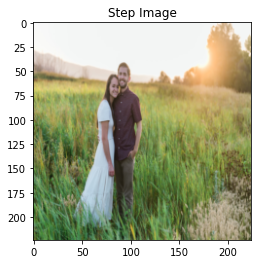

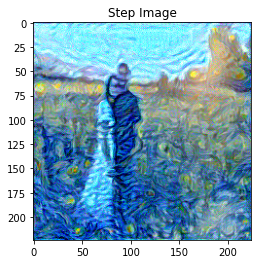

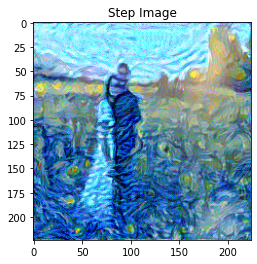

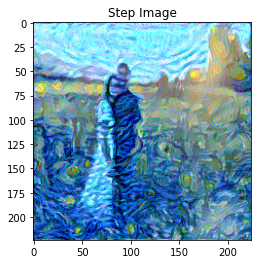

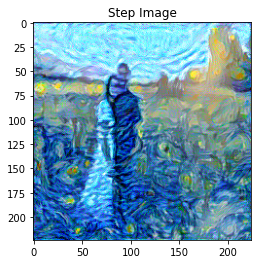

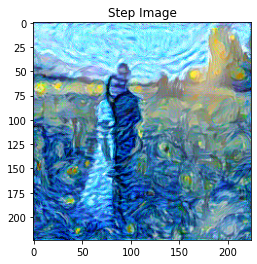

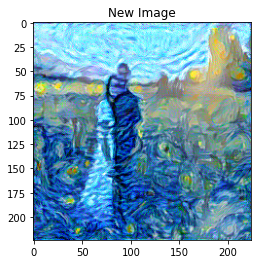

In [39]:
# Start with a copy of the content image
content_img_copy = content_image.clone()
content_img_copy.requires_grad = True
#plt.figure()
#display(content_img_copy, title='Old Image')

#content_img_copy = torch.randn(content_img_copy.data.size()).cuda()
#content_img_copy.requires_grad = True
#print(content_img_copy)
# Run the optimizer on the images to change the image
optimizer = optim.Adam([content_img_copy], lr=1e-1)
content_loss = ContentLoss(outputs_content.detach())
style_losses = []
for item in outputs_style:
  print(outputs_style[item].size())
  style_losses.append(StyleLoss(outputs_style[item].detach()))

for step in range(300):
  #print('starting step')
  optimizer.zero_grad()
  y_style = VGG_style(content_img_copy)
  y_content = VGG_content(content_img_copy)
  #print('y_style size: ', y_style.size())
  #print('y_content size: ', y_content.size())
  computed_style_losses = []
  for losses in range(len(style_losses)):
    #print(style_losses[losses])
    curr_loss = style_losses[losses]
    computed_style_losses.append(curr_loss(list(y_style.values())[losses]))
  sty_loss = sum(computed_style_losses)
    #print(curr_loss)
  cont_loss = content_loss(y_content[cont_layer])
  #print(cont_loss)
  #loss = (cont_loss * 100) + (sty_loss * 1000000)
  cont_loss.backward()
  sty_loss.backward()
  #loss.backward()
  if step % 50 == 0:
    plt.figure()
    display(content_img_copy.clamp(0, 1), title='Step Image')
    print('Step: ', step)
    print('Style loss: ', sty_loss.item())
    print('Content loss: ', cont_loss.item())
  optimizer.step()
#  using the loss of the style and content layers
#  to backpropagate errors 
  

# Show the image
plt.figure()
display(content_img_copy.clamp(0, 1), title='New Image')

# I WILL NEED TO MAKE SURE THAT THE IMAGE TENSOR REQUIRES GRADIENT .requires_grad()
# Or I can also wrap it in an nn.Paramter()
# I also need to pass that image tensor to the optimizer

### Part 4

Show that you understand style transfer by describing the key equations of (Gatys 2016) in your own words.

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts. $\mathcal{L}_{content} (\vec{p},\vec{x},l) = \frac{1}{2} \sum_{i,j} (F_{ij}^l - P_{ij}^l)^2$ <br>
$\vec{p}$ = The original image <br>
$\vec{x}$ = The image generated <br>
<i>l<i> = The layer selected to be the content layer <br>
This equation is (1/2) multiplied by the MSE of the original content feature layer output compared to the generated image's content feature layer

- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts. <br> $G_{ij}^l = \sum_k F_{ik}^l F_{jk}^l$ <br>
$G_{ij}^l$ = sum of the inner products between the vectorised feature map of the original style layers $F_{ik}^l$ and the generated style layers $F_{jk}^l$ for each of the layers <i>k<i>

- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts. $E_l = \frac{1}{4 N_l^2 M_l^2} \sum_{i,j} (G_{ij}^l - A_{ij}^l)^2$ <br>
Minimize the mean-squared distance between the entries of the Gram matrix $G_{ij}^l$ from the original image and the Gram matrix of the image to be generated $A_{ij}^l$. N and M are from the dimentions of the Gram Matrix.

- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts. $\mathcal{L}_{style} (\vec{a}, \vec{x}) = \sum_{l=0}^L w_l E_l$ <br>
$\vec{a}$ = The original image <br>
$\vec{x}$ = The generated image <br>
$w_l$ = weighting factors of the contribution of each layer to the total loss <br>
This is the MSE of the weight factors multiplied by the Minimized MSE of the Gram Matrix of the Original image compared to the Gram Matrix of the generated image.


**DONE:** <br>
SEE ABOVE FOR THE DESCRIPTIONS